# Lecture 19 - Natural Language Generation

In this notebook we will learn how to generate natural language using transformer language models.

Below is the overview of this notebook.

1. Test different decoding methods on GPT-2

2. Fine tune GPT-2 to tweet like a Twitter user

3. Generate controlled text using CTRL

# Google Colab

If you have a Google account you can load this notebook in Google Colab with the link below:
https://colab.research.google.com/github/zlisto/natural_language_generation/blob/main/Lecture%2019%20-%20Natural%20Language%20Generation.ipynb

This will be most useful for folks who could not get the `transformers` package to work properly.  One warning: I was not able to get the CTRL section of this notebook to work on Colab.

## Install Packages

You will need to install the transformers package if you have not already (you probably did for HW 6).

In [ ]:
!pip install transformers

## Import Packages

We will import the `pipeline` module from `transformers`, which makes generating text really easy.

In [16]:
from transformers import pipeline
from collections import Counter
import sqlite3, sys, os
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

## Helper Functions

We will use the function `display_text` to display the output generated text.

In [2]:
def display_text(outputs):
    for count,output in enumerate(outputs):
        text = output['generated_text']
        text = text.replace("\n"," ").replace("\r"," ")
        print(f"{count}: {text}")
    return None

# Decoding Methods

We will begin by testing diffrenent decoding methods for generating text from a language model.  The methods include

1. Greedy search

2. Beam search

3. Sampling

4. Sampling with temperature

5. Top-k sampling

6. Top-p sampling 

Much of this code comes from the following blog:

https://huggingface.co/blog/how-to-generate

## Load GPT-2

We will be generating text using the GPT-2 transformer.  We set `model_name = "gpt-2"` and then create `generator` with the `pipeline` function.  `generator` will be a function that lets us generate text very easily once we specify a model.  It automatically loads the proper tokenizer for the model, tokenizes the text, and generates the text.  

In [3]:
%%time
model_name = "gpt2"
generator = pipeline('text-generation',model=model_name)

Some weights of GPT2Model were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wall time: 6.34 s


## Set Input Parameters

We need to set some input parameters to generate text.

1. `input_text` = the starting text string for your generated text

2. `max_length` = the number of words in your generated text

3. `num_return_sequences` = number of texts you want to generate (this is for the sampling methods)

In [4]:
input_text = "Joe Biden's infrastructure bill is"
max_length = 30
num_return_sequences = 5

## Greedy Search

To use greedy search, we call `generator` with the `input_text`, `max_length`, and set `do_sample=False`.  The output of `generator` is `outputs` which is a list of the generated text objects.  We use `display_text` to print out the generated text. If you want to learn about the exact structure of `outputs`, you can look at the details of `display_text`.

In [5]:
outputs =generator(input_text, 
                         max_length=max_length, 
                           do_sample = False,
                        pad_token_id = 50256)

print(f"Greedy search\nModel = {model_name}\n"+ 50*"-")
display_text(outputs)

Greedy search
Model = gpt2
--------------------------------------------------
0: Joe Biden's infrastructure bill is a disaster. It's a disaster for the American people. It's a disaster for the American economy. It's a


## Beam Search

To use beam search we have to set the number of beams `num_beams`.  Then we use `generator` with a few additional parameters:

1. `early_stopping=True` so that generation is finished when all beams reach the End Of Sentence (EOS) token.

2. `num_beams=num_beams` so we track `num_beams` beams while generating the text.

In [6]:
num_beams = 5

outputs = generator(input_text, 
                         max_length=max_length,
                        pad_token_id = 50256,                         
                        num_beams=num_beams, 
                        early_stopping=True,
                        do_sample = False
                        )

print(f"Beam search with {num_beams} beams:\nModel = {model_name}\n"+ 50*"-")
display_text(outputs)

Beam search with 5 beams:
Model = gpt2
--------------------------------------------------
0: Joe Biden's infrastructure bill is a disaster. It's a disaster for the American people. It's a disaster for our economy. It's a disaster


## Sampling

To generate text by sampling from the language model, we call `generator` with the following parameters:

1. `do_sample = True`

2. `num_return_sequences=num_return_sequences` because we will be generating multiple texts.

In [7]:
outputs = generator(input_text, 
                         max_length=max_length,
                        pad_token_id = 50256,                         
                        num_return_sequences=num_return_sequences,
                         do_sample=True
                        )

print(f"Sampling\nModel = {model_name}\n"+ 50*"-")
display_text(outputs)

Sampling
Model = gpt2
--------------------------------------------------
0: Joe Biden's infrastructure bill is a bipartisan project, but has been largely ignored outside of the Democratic Party, Politico reports. Senate Majority Leader Mitch McConnell (
1: Joe Biden's infrastructure bill is just one of the problems the Left is hoping of solving. They're using Obamacare or something like it in general,
2: Joe Biden's infrastructure bill is not an option for Congress. And with the Senate just days away, it's been determined that Republicans will only push another
3: Joe Biden's infrastructure bill is an attempt to undermine the Affordable Care Act.  Obama proposed the bill in March, and it narrowly passed on the
4: Joe Biden's infrastructure bill is a 'small step' towards the GOP's 'endurance' plan, but that doesn't mean it can't get


## Sampling with Temperature

Sampling with temperature requires us to set the `temperature`.  Setting `temperature=1` is equivalent to normal sampling from the language model.  Setting `temperature=0` is equivalent to greedy search.   If you set `temperature` to be greater than 1, you will get more random text, while if `temperature` is less than 1 you get higher probability text.  

We use `generator` with the same parameters as for sampling, but with an additional parameter:

1. `temperature = float(temperature)`.  We need `temperature` to be a float number for the code to work.


In [8]:
temperature = 1.2

outputs = generator(input_text, 
                         max_length=max_length,
                        pad_token_id = 50256,                         
                        num_return_sequences=num_return_sequences,
                         do_sample=True,
                         temperature = float(temperature)
                        )

print(f"Sampling with temperature = {temperature}\nModel = {model_name}\n"+ 50*"-")
display_text(outputs)

Sampling with temperature = 1.2
Model = gpt2
--------------------------------------------------
0: Joe Biden's infrastructure bill is similar to the House-passed bill the House passed, H.L. 2158, a compromise bill called the
1: Joe Biden's infrastructure bill is now "not as good" as the bill he was hoping for. (It will, presumably, likely face Republican opposition
2: Joe Biden's infrastructure bill is not a substitute for a $3 trillion budget that includes huge cuts to welfare — and it'd have nothing to do with
3: Joe Biden's infrastructure bill is even more problematic, as he doesn't have a lot of votes on the Senate floor, let alone on the House floor
4: Joe Biden's infrastructure bill is dead, and the House passed a bill late Thursday evening (Monday) night as expected and before it began to emerge that


## Top-k Sampling

We first set `k` equal to the size of the sampling set of words.  Then we call generator with the same parameters as for sampling or sampling with temperature, plus one additional parameter:

1. `top_k=k`

In [9]:
k = 5

outputs = generator(input_text,
                         max_length=max_length,
                        pad_token_id = 50256,                         
                        num_return_sequences=num_return_sequences,
                         do_sample=True, 
                        top_k=k,
                        )

print(f"Top-k Sampling with k = {k}\nModel = {model_name}\n"+ 50*"-")
display_text(outputs)

Top-k Sampling with k = 5
Model = gpt2
--------------------------------------------------
0: Joe Biden's infrastructure bill is a great example of a bipartisan effort to get things done."  Biden is a longtime Democratic critic and a former
1: Joe Biden's infrastructure bill is a big win for the Democratic Party. It's a big win for the middle class, it's a big win for
2: Joe Biden's infrastructure bill is a disaster for the American people, and we're going to fight back against it," he said.  The Senate
3: Joe Biden's infrastructure bill is now up for re-election this year.  In addition to the $1 billion in infrastructure funding, the bill
4: Joe Biden's infrastructure bill is a big win. He has a big chance to win it.  He's not going to get it done.


## Top-p Sampling

We first set `p` to be the probability of words in the sample set.  Then we call generator with the same parameters as for sampling or sampling with temperature, plus one additional parameter:

1. `top_p = p`


In [10]:
p=0.92
temperature = 0.7

outputs = generator(input_text, 
                         max_length=max_length,
                        pad_token_id = 50256,                         
                        num_return_sequences=num_return_sequences,
                         do_sample=True, 
                       temperature = float(temperature),
                        top_p = p
                        )

print(f"Top-p Sampling with p = {p:.3f}\nModel = {model_name}\n" + 50*"-")
display_text(outputs)

Top-p Sampling with p = 0.920
Model = gpt2
--------------------------------------------------
0: Joe Biden's infrastructure bill is a great way to get your bill through the Senate.  You can also get a copy of the Senate's legislation
1: Joe Biden's infrastructure bill is not only not going to pass the Senate but it will not pass the House.  "This is a big deal
2: Joe Biden's infrastructure bill is a disaster. It would leave the federal government with a $8 billion deficit by 2027, which is about $4
3: Joe Biden's infrastructure bill is about to get a vote.  The Senate has yet to vote on a bill that would increase the minimum wage to
4: Joe Biden's infrastructure bill is now in the Senate, and it will need to be passed by the full Senate. The Democratic leadership wants to see a


# Generating Synthetic Tweets

## Fine Tune GPT-2 on a Twitter User's Tweets

We are next going to fine tune GPT-2 using the tweets of a Twitter user.  We can do this using the following notebook found on Google Colab:
https://colab.research.google.com/github/borisdayma/huggingtweets/blob/master/huggingtweets-demo.ipynb#scrollTo=CpxBQYF88AHJ
Just follow the instructions on the notebook to fine tune GPT-2.  The model will then be saved to the HuggingTweets repository.  You will need a Google account to use the notebook. 

Details about this code can be found here:
https://wandb.ai/wandb/huggingtweets/reports/HuggingTweets-Train-a-Model-to-Generate-Tweets--VmlldzoxMTY5MjI



## Load a Fine-Tuned Model from HuggingTweets

There are many pre-trained models on HuggingTweets: https://huggingface.co/huggingtweets.  To choose one, set `screen_name` equal to the Twitter user whose model you want to use.  Then created `generator_tweet` using the `pipeline` function.


In [11]:
screen_name = "AOC"
generator_tweet = pipeline('text-generation',
                     model=f"huggingtweets/{screen_name.lower()}")



## Generate Tweet in Voice of a Twitter User

Use `generator_tweet` to generate tweets in the voice of the Twitter user.  Just set the input parameters:

1. `input_text_tweet` = starting text of tweet

2. `max_length` = number of words in tweet

3. `num_return_sequences` = number of tweets to generate

4. `temperature` = temperature for sampling

5. `p` = probability of sample set for top-p sampling

In [12]:
input_text_tweet = "Today"
max_length = 30
num_return_sequences = 5
temperature = 0.8
p = 0.95

outputs =generator_tweet(input_text_tweet, 
                       max_length=max_length,
                       num_return_sequences= num_return_sequences,
                       temperature = float(temperature),
                       do_sample = True,
                       top_p = p,
                       pad_token_id=50256)

print(f"Fake Tweets of {screen_name}\n"+50*"-")
display_text(outputs)

Fake Tweets of AOC
--------------------------------------------------
0: Today @RashidaTlaib is tweeting about the fact that I helped write and vote for the Green New Deal in “21”
1: Today is our day! 🙏🏽‍♀️‍♀️‍♀️‍♀
2: Today is a big day. We need to have a $1 trillion stimulus package. I want to thank President Obama, Vice President Biden, & many
3: Today: To help make this happen, we must: - Establish a Green New Deal - Create $100k+ local relief checks - Create $
4: Today we are unveiling a new policy that allows for Medicare-for-All:


# Language Model Probability Distribution

To explore the fine tuned language model, we can plot the probability distribution of the next word given an input text.  We do this as follows.

1. Choose your input text

2. Sample many words from the language model given the input text

3. Make a histogram of the sampled words

## Helper function

The function `sample_words` will sample words from the language model given an input text.  It's input parameters are 

1. `input_text` = input text (make sure it does not end in a space, and use common words)

2. `generator` = language model generator from which you will be sampling words

3. `nsamples` = number of words to sample


`sample_words` returns a dataframe with columns `word` which has the words and `freq` which has the frequency count for the sampled words.

In [14]:
def sample_words(input_text,generator,nsamples):
    max_length = len(input_text.split(" "))+1
    outputs = generator(input_text, 
                             max_length=max_length,
                            pad_token_id = 50256,                         
                            num_return_sequences=nsamples,
                             do_sample=True, 
                            top_k=0
                            )

    W = []
    for count,output in enumerate(outputs):
        text = output['generated_text']
        text = text.replace("\n"," ").replace("\r"," ").replace(input_text,"")
        W.append(text)
    counter = Counter(W)

    words = [x for x in counter.keys()]
    freqs = [x for x in counter.values()]

    df_freq = pd.DataFrame({'word':words,'freq':freqs})
    df_freq.sort_values(by = 'freq', ascending = False, inplace = True)
    df_freq.head()
    return df_freq




## Sample Words from GPT-2 and Fine Tuned GPT-2

Set the input text with the variable `input_text_sample`.  It's important not to put a space at the end of `input_text_sample` because of the way the generated sequence length is calculated.  Then sample `nsamples` words from the GPT-2 generator, called `generator`, and the fined tuned GPT-2 generator, called `generator_tweet`. 

The dataframe with the word frequencies for GPT-2 is called `df_gpt2` and the dataframe with the word frequencies for fined tuned GPT-2 is called `df_gpt2_ft`

In [19]:
%%time 

input_text_sample = 'Today'
nsamples = 100

df_gpt2 =  sample_words(input_text_sample, generator,nsamples)
df_gpt2_ft = sample_words(input_text_sample, generator_tweet, nsamples)


Wall time: 1.34 s


## Histograms of Word Distributions for GPT-2 and Fined Tuned GPT-2

To visualize the difference in the distributions for GPT-2 and fine tuned GPT-2, make a histogram of the sampled words for the two models.

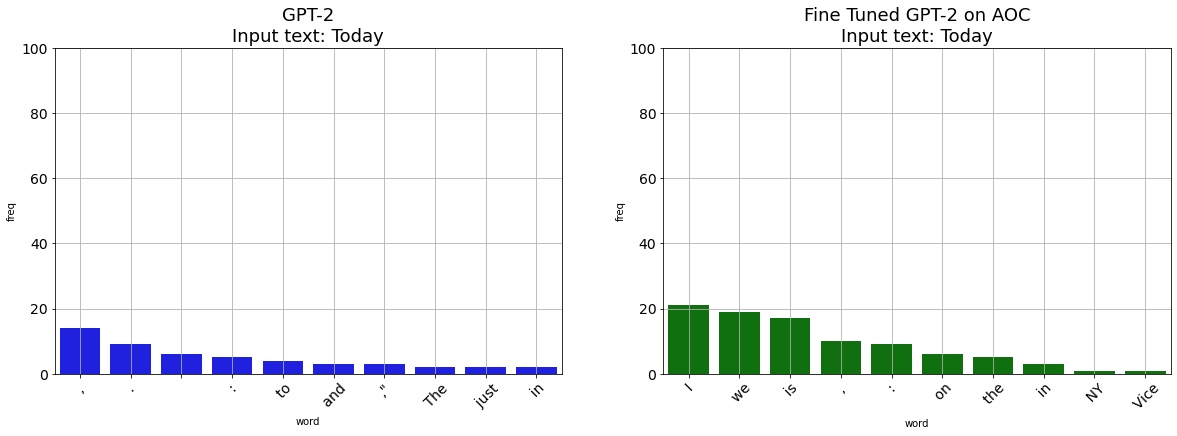

In [21]:
wmax = 10
rot = 45
ymax = nsamples

fig = plt.figure(figsize = (20,6))
plt.subplot(1,2,1)
ax = sns.barplot(data = df_gpt2[0:wmax], x = 'word', y = 'freq', color = 'blue')
plt.title(f"GPT-2\nInput text: {input_text_sample}",fontsize = 18)
ax.set_xticklabels(ax.get_xticklabels(),rotation = rot)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.grid()
plt.ylim([0,ymax])

plt.subplot(1,2,2)
ax=sns.barplot(data = df_gpt2_ft[0:wmax], x = 'word', y = 'freq', color = 'green')
plt.title(f"Fine Tuned GPT-2 on {screen_name}\nInput text: {input_text_sample}",fontsize = 18)

ax.set_xticklabels(ax.get_xticklabels(),rotation = rot)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.grid()
plt.ylim([0,ymax])

plt.show()

# Controlled Natural Language Generation: CTRL

We will use CTRL to generaate controlled text.  The original CTLR paper can be found here: https://arxiv.org/pdf/1909.05858.pdf


## Load CTRL

Set `model_name="ctrl"` and then created `generator_ctrl` using the `pipeline` function.

WARNING: CTRL is pretty big (~6 GB) so this step may take a few minutes.



In [22]:
%%time
model_name = "ctrl"
generator_ctrl = pipeline('text-generation',
                     model=model_name)

Wall time: 3min 3s


## Generate Controlled Text


Use `generator_ctrl` to generate controlled text.  Just set the input parameters:

1. `input_text_ctrl` = starting text 

2. `control_code` = control code for text.  A list of control codes can be found here:https://github.com/salesforce/ctrl/blob/master/control_codes.txt

3. `max_length` = number of words in text

4. `num_return_sequences` = number of texts to generate

5. `temperature` = temperature for sampling

6. `p` = probability of sample set for top-p sampling




In [24]:
input_text_ctrl = "I feel"
control_code = "Food"
max_length = 30
num_return_sequences = 5
temperature = 0.9
p = 0.9


In [25]:
%%time

input_text_control_code = f"{control_code} {input_text_ctrl}"

outputs = generator_ctrl(input_text_control_code,  
                         max_length=max_length, 
                         temperature=float(temperature),
                         do_sample = True,
                        num_return_sequences=num_return_sequences,
                        pad_token_id = 50256,
                        top_p = p,
                       )

print(f"CTRL Control code: {control_code}\n"+50*"-")
display_text(outputs)

CTRL Control code: Feminism
--------------------------------------------------
0: Feminism I feel guilty for feeling this way. It also feels like I'm the only person with an issue with it.     Has anyone else had any experience with
1: Feminism I feel guilty because of the fact that I'm not actively working on myself at the moment.     I feel really sad when I'm sad about things and
2: Feminism I feel like I've lost a friend and I've been trying to get her to text me back for a month now. I miss her so much. I feel
3: Feminism I feel like this is an important part of my journey to self-acceptance, but is there a way to find the strength to not let my weight get
4: Feminism I feel like I'm the only one. I have no friends here, and I'm very lonely.       Edit: I just wanted to add that I am
Wall time: 23.8 s


## Generate Text with Controlled Sentiment

For the `Rating` control code, you can add a number between 1 and 5 to produce text with a negative or positive sentiment.

In [30]:
input_text_ctrl = "I feel"
control_code = "Review Rating: 5.0"
max_length = 30
num_return_sequences = 5
temperature = 1.2
p = 0.9



In [31]:
%%time

input_text_control_code = f"{control_code} {input_text_ctrl}"
outputs = generator_ctrl(input_text_control_code,  
                         max_length=max_length, 
                         temperature=float(temperature),
                         do_sample = True,
                        num_return_sequences=num_return_sequences,
                        pad_token_id = 50256,
                        top_p = p,
                       )

print(f"CTRL Control code: {control_code}\n"+50*"-")
display_text(outputs)

CTRL Control code: Review Rating: 5.0
--------------------------------------------------
0: Review Rating: 5.0 I feel comfortable in reviewing   Rating: 4.0   It's a cute storyI love this story that the world love so much . .
1: Review Rating: 5.0 I feel bad that I hate it:-::   Rating: 3.0   I would recomend this book for young kids.
2: Review Rating: 5.0 I feel like I have discovered a long forgotten part of my family history.The The The The the the the t e o . .The
3: Review Rating: 5.0 I feel this is a review to let everyone know what was on the first DVD. SecondThe is a re-release of the original theatrical release
4: Review Rating: 5.0 I feel in love with the city :&#34;   Rating: 5.0   I LOVE this song, album this this it t s


## Mix Topic and Sentiment

We can append multiple control codes to create text about a topic with a given sentiment

In [34]:
input_text_ctrl = "This restaurant"

control_code = "Food Review Rating: 5.0"
max_length = 30
num_return_sequences = 5
temperature = 0.9
p = 0.9


In [35]:
%%time

input_text_control_code = f"{control_code} {input_text_ctrl}"
outputs = generator_ctrl(input_text_control_code,  
                         max_length=max_length, 
                         temperature=float(temperature),
                         do_sample = True,
                        num_return_sequences=num_return_sequences,
                        pad_token_id = 50256,
                        top_p = p,
                       )

print(f"CTRL Control code: {control_code}\n"+50*"-")
display_text(outputs)

CTRL Control code: Food Review Rating: 5.0
--------------------------------------------------
0: Food Review Rating: 5.0 This restaurant is amazing. It has great food and the ambiance is perfect. It is small but it is very convenient to go out
1: Food Review Rating: 5.0 This restaurant has been reviewed in the New York Times and was named one of the top ten restaurants in the United States by Food
2: Food Review Rating: 5.0 This restaurant has been a hit every time I've been there. The service is amazing. The food is outstanding. This is a great place
3: Food Review Rating: 5.0 This restaurant has some of the best pizza I've ever had. And they don't even have to go through the pizzeri- - -
4: Food Review Rating: 5.0 This restaurant was an excellent place to have a meal and a great time watching the game.   Rating: 5.0   As always when
Wall time: 15.1 s


In [36]:
input_text_ctrl = "This restaurant"

control_code = "Food Review Rating: 1.0"

input_text_control_code = f"{control_code} {input_text_ctrl}"
outputs = generator_ctrl(input_text_control_code,  
                         max_length=max_length, 
                         temperature=float(temperature),
                         do_sample = True,
                        num_return_sequences=num_return_sequences,
                        pad_token_id = 50256,
                        top_p = p,
                       )

print(f"CTRL Control code: {control_code}\n"+50*"-")
display_text(outputs)

CTRL Control code: Food Review Rating: 1.0
--------------------------------------------------
0: Food Review Rating: 1.0 This restaurant was great when it first opened. It was a little out of the way but then came the new place that has a
1: Food Review Rating: 1.0 This restaurant is not the one you are looking for. It is a chain burger joint. No matter what you order, the food will never
2: Food Review Rating: 1.0 This restaurant only serves 3 meals a day and has 4 different wine listings: Red Zinfandel Vino, and a white
3: Food Review Rating: 1.0 This restaurant is a terrible place for children. We were there for my son's birthday and I had to give the children their napkins.
4: Food Review Rating: 1.0 This restaurant was supposed to be an upscale steakhouse. The food was overcooked and the service was rude. I recommend a meal at
